# 1.dfの作成

In [1]:
import pandas as pd

input = "/Users/macmini/Documents/多目的最適化の理論構築/train/result0.xlsx"
df_all = pd.read_excel(input)

X_cols = ["F12","F13","F14","F15","F16","F20","F0","R12","R13","R14","R15","R16","R20","R0"]
x_cols_hammett = ["Index 14","Index 15","Index 16","Index 20", "Index 0"]
y_cols_m = ["mwave1", "msrength1"]
y_cols_d = ["dwave1", "dstrength1"]

# 2.FPの作成

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def create_fp_dataframe(df, smiles_col="dimer_smi", radius=2, n_bits=2048):
    """
    DataFrame から指定した SMILES 列を読み込み、Morgan フィンガープリント
    をビットベクトル化して新しい DataFrame として返す。

    Args:
        df (pd.DataFrame): 元の DataFrame（インデックスはそのまま利用）
        smiles_col (str): SMILES が入っているカラム名
        radius (int): Morgan fingerprint の半径
        n_bits (int): フィンガープリント長

    Returns:
        pd.DataFrame: 行数は df と同じ、列は FP_0～FP_{n_bits-1}
    """
    # 1. SMILES リスト取得
    smiles_list = df[smiles_col].tolist()
    
    # 2. フィンガープリント生成
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=int))
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    
    # 3. ndarray 化＆DataFrame 化
    fps_array = np.vstack(fps)  # shape = (len(df), n_bits)
    col_names = [f"FP_{i}" for i in range(n_bits)]
    df_fp = pd.DataFrame(fps_array, columns=col_names, index=df.index)
    
    return df_fp

# 使い方例

df_fp = create_fp_dataframe(df_all, smiles_col="dimer_smi", radius=2, n_bits=2048)
print(df_fp.shape)
df_fp.head()

# csv化
output_fp = "fp.csv"
df_fp.to_csv(output_fp, index=False)


(256, 2048)


In [3]:
x_cols_fp = [f"FP_{i}" for i in range(2048)]
print(x_cols_fp[:5])  # 最初の5つのフィンガープリント列名を表示

['FP_0', 'FP_1', 'FP_2', 'FP_3', 'FP_4']


In [4]:
df_all_FP = pd.concat([df_all, df_fp], axis=1)

# 3.小規模探索検証

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.stats import ncx2
import warnings

warnings.filterwarnings("ignore")

def l2_lcb_exact(means: np.ndarray,
                 variances: np.ndarray,
                 target: np.ndarray,
                 p: float = 0.05,
                 eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    lam    = diff2 / gamma2
    q      = ncx2.ppf(1 - p, df=k, nc=lam)
    q      = np.nan_to_num(q, nan=0.0, posinf=0.0, neginf=0.0)
    return -gamma2 * q

def l2_ei(means: np.ndarray,
          variances: np.ndarray,
          target: np.ndarray,
          y_min: float,
          eps: float = 1e-8) -> np.ndarray:
    k      = means.shape[1]
    gamma2 = np.maximum(variances.mean(axis=1), eps)
    diff2  = np.sum((means - target)**2, axis=1)
    nc     = diff2 / gamma2
    x      = y_min / gamma2
    t1     = y_min * ncx2.cdf(x, df=k,   nc=nc)
    t2     = gamma2 * (
              k   * ncx2.cdf(x, df=k+2, nc=nc)
            + nc  * ncx2.cdf(x, df=k+4, nc=nc)
          )
    return np.maximum(0, t1 - t2)

def fit_multi_gpy(X: np.ndarray, Y: np.ndarray):
    models = []
    for i in range(Y.shape[1]):
        kern = GPy.kern.Exponential(input_dim=X.shape[1], ARD=False)
        m    = GPy.models.GPRegression(X, Y[:, [i]], kern)
        m.Gaussian_noise.variance = 1e-6
        m.Gaussian_noise.variance.fix()
        m.optimize(messages=False, max_iters=5)
        models.append(m)
    return models

def predict_multi_gpy(models, X: np.ndarray):
    mus, vars_ = [], []
    for m in models:
        mu, var = m.predict(X)
        mus.append(mu.flatten())
        vars_.append(var.flatten())
    return np.column_stack(mus), np.column_stack(vars_)

def compare_methods_gpy(df: pd.DataFrame,
                        X_cols: list,
                        Y_cols: list,
                        target: np.ndarray,
                        init_size: int,
                        trials: int = 100,
                        p: float = 0.05,
                        budget: int = None,
                        methods: list = ('lcb', 'ei', 'rand')):
    """
    Compare methods ('lcb','ei','rand') over multiple runs,
    ensuring that LCB and EI start from the same initial points each run.
    Returns:
      avg_dict: {method: mean cumulative hits array}
      history:  {method: array shape (trials, n_iter)}
      df_avg:   DataFrame of mean cumulative hits per iteration
    """
    N = len(df)
    if budget is None:
        n_iter = N - init_size
    else:
        n_iter = budget
    top_n = int(np.ceil(N * 0.05))

    # Precompute global distances and top indices
    scaler_global   = StandardScaler().fit(df[Y_cols].values)
    Y_scaled        = scaler_global.transform(df[Y_cols].values)
    target_scaled   = scaler_global.transform(target.reshape(1, -1)).flatten()
    dists           = np.linalg.norm(Y_scaled - target_scaled, axis=1)
    top_idx         = set(np.argsort(dists)[:top_n])

    history = {m: np.zeros((trials, n_iter), dtype=int) for m in methods}

    for run in range(trials):
        # fixed permutation for this run
        rng       = np.random.RandomState(run + 1)
        perm      = rng.permutation(N)
        train_base = list(perm[:init_size])
        cand_base  = list(perm[init_size:])

        for method in methods:
            # copy initial indices
            train_idx = train_base.copy()
            cand_idx  = cand_base.copy()
            cumulative = sum(i in top_idx for i in train_idx)

            # initial training data arrays
            X_train = df.iloc[train_idx][X_cols].values
            Y_train = df.iloc[train_idx][Y_cols].values

            # if using model-based method, fit initial GPs
            if method in ('lcb', 'ei'):
                scaler = StandardScaler().fit(Y_train)
                Y_train_s = scaler.transform(Y_train)
                models    = fit_multi_gpy(X_train, Y_train_s)
                target_s  = scaler.transform(target.reshape(1, -1)).flatten()

            for it in range(n_iter):
                X_cand = df.iloc[cand_idx][X_cols].values

                if method == 'lcb':
                    means, vars_ = predict_multi_gpy(models, X_cand)
                    scores       = l2_lcb_exact(means, vars_, target_s, p)
                    pick         = np.argmax(scores)

                elif method == 'ei':
                    means, vars_ = predict_multi_gpy(models, X_cand)
                    y_min        = np.min(np.sum((Y_train_s - target_s)**2, axis=1))
                    scores       = l2_ei(means, vars_, target_s, y_min)
                    pick         = np.argmax(scores)

                else:  # 'rand'
                    pick = rng.randint(len(cand_idx))

                chosen = cand_idx.pop(pick)
                if chosen in top_idx:
                    cumulative += 1
                history[method][run, it] = cumulative

                # update training data
                new_X = df.iloc[[chosen]][X_cols].values
                new_Y = df.iloc[[chosen]][Y_cols].values
                X_train = np.vstack([X_train, new_X])
                Y_train = np.vstack([Y_train, new_Y])

                if method in ('lcb', 'ei'):
                    scaler      = StandardScaler().fit(Y_train)
                    Y_train_s   = scaler.transform(Y_train)
                    target_s    = scaler.transform(target.reshape(1, -1)).flatten()
                    models      = fit_multi_gpy(X_train, Y_train_s)

    # compute averages
    avg_dict = {m: history[m].mean(axis=0) for m in methods}
    df_avg   = pd.DataFrame(avg_dict, index=np.arange(1, n_iter + 1))
    df_avg.index.name = 'iteration'
    return avg_dict, history, df_avg

def plot_comparison(df_avg: pd.DataFrame):
    plt.figure(figsize=(8, 5))
    for method in df_avg.columns:
        plt.plot(df_avg.index, df_avg[method], label=method.upper())
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative Top 5% Hits")
    plt.title("GPy Search Method Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# avg_dict, history, df_avg = compare_methods_gpy(
#     df_all, X_cols, Y_cols, target,
#     init_size=5, trials=50, p=0.1, budget=200,
#     methods=['lcb','ei']
# )
# plot_comparison(df_avg)


In [14]:
X_cols_FP = [f"FP_{i}" for i in range(2048)]
for i, v in enumerate(X_cols_FP):
    print(f"{i:3d}: {v}")


# df_FPの0しかないカラムを抜く
df_FP_NONE0 = df_fp.loc[:, (df_fp != 0).any(axis=0)]
X_cols_FP_NONE0 = df_FP_NONE0.columns.tolist()
print(f"FP columns with non-zero values: {len(X_cols_FP_NONE0)}")


  0: FP_0
  1: FP_1
  2: FP_2
  3: FP_3
  4: FP_4
  5: FP_5
  6: FP_6
  7: FP_7
  8: FP_8
  9: FP_9
 10: FP_10
 11: FP_11
 12: FP_12
 13: FP_13
 14: FP_14
 15: FP_15
 16: FP_16
 17: FP_17
 18: FP_18
 19: FP_19
 20: FP_20
 21: FP_21
 22: FP_22
 23: FP_23
 24: FP_24
 25: FP_25
 26: FP_26
 27: FP_27
 28: FP_28
 29: FP_29
 30: FP_30
 31: FP_31
 32: FP_32
 33: FP_33
 34: FP_34
 35: FP_35
 36: FP_36
 37: FP_37
 38: FP_38
 39: FP_39
 40: FP_40
 41: FP_41
 42: FP_42
 43: FP_43
 44: FP_44
 45: FP_45
 46: FP_46
 47: FP_47
 48: FP_48
 49: FP_49
 50: FP_50
 51: FP_51
 52: FP_52
 53: FP_53
 54: FP_54
 55: FP_55
 56: FP_56
 57: FP_57
 58: FP_58
 59: FP_59
 60: FP_60
 61: FP_61
 62: FP_62
 63: FP_63
 64: FP_64
 65: FP_65
 66: FP_66
 67: FP_67
 68: FP_68
 69: FP_69
 70: FP_70
 71: FP_71
 72: FP_72
 73: FP_73
 74: FP_74
 75: FP_75
 76: FP_76
 77: FP_77
 78: FP_78
 79: FP_79
 80: FP_80
 81: FP_81
 82: FP_82
 83: FP_83
 84: FP_84
 85: FP_85
 86: FP_86
 87: FP_87
 88: FP_88
 89: FP_89
 90: FP_90
 91: FP_9

# FPでの探索

Running for p = 0.70...


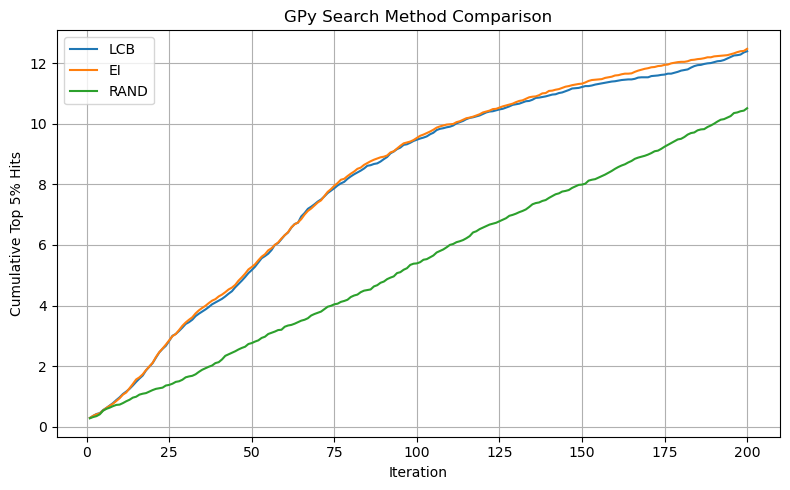

: 

In [ ]:
p_candidates =[0.7]
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])
for i in p_candidates:
    print(f"Running for p = {i:.2f}...")
    avg_counts, raw_hist,df_avg  = compare_methods_gpy(
        df_all_FP, X_cols_FP_NONE0, Y_cols, target,
        init_size=5,
        trials=100,
        p=i,
        budget=200,
        methods=["lcb", "ei", "rand"]
    )

# --- 結果保存 & プロット ---
    df_avg.to_csv(f"/Users/macmini/Documents/FP_NONE0_avg_hits_p_{i:.2f}.csv", index=True)
    plot_comparison(df_avg)

# FP_SLでの予測

Running for p = 0.70...


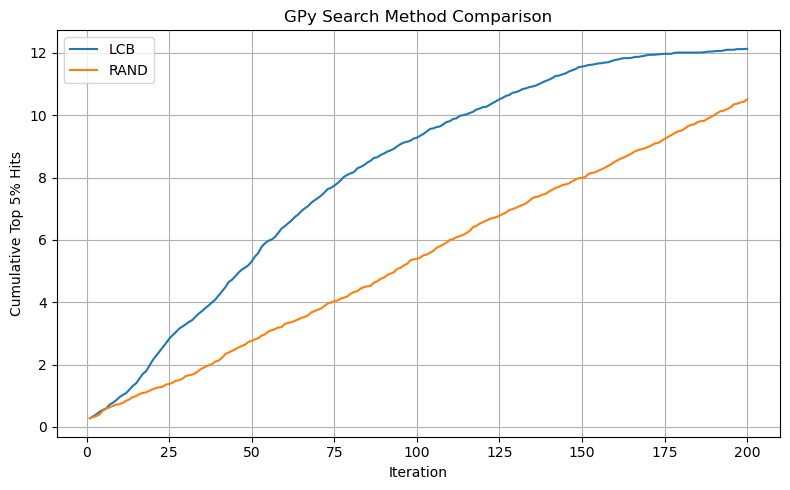

In [22]:
X_cols_all = ["F12","F13","F14","F15","F16","F20","F0",
              "R12","R13","R14","R15","R16","R20","R0"] + x_cols_fp
Y_cols = ["dwave1","dstrength1"]
target = np.array([530.64, 0.005])
p_candidates =[0.7]
for i in p_candidates:
    print(f"Running for p = {i:.2f}...")
    avg_counts, raw_hist,df_avg  = compare_methods_gpy(
        df_all_FP, X_cols_all, Y_cols, target,
        init_size=5,
        trials=100,
        p=i,
        budget=200,
        methods=["lcb", "rand"]
    )

# --- 結果保存 & プロット ---
    df_avg.to_csv(f"/Users/macmini/Documents/FP_+sL_.csv", index=True)
    plot_comparison(df_avg)

# 平均距離差を解析

In [ ]:
def compare_cum_target_regret(df: pd.DataFrame,
                              X_cols: list,
                              Y_cols: list,
                              target: np.ndarray,
                              methods=('lcb','ei'),
                              init_size=5,
                              trials=50,
                              p=0.05,
                              budget: int = None):
    """
    Compare methods by average per-iteration target regret,
    record chosen indices, and record the actual Y values picked.
    Returns:
      df_results: {method: DataFrame(iteration x objectives) of average cumulative regret}
      df_picks:   {method: DataFrame(runs x iterations) of chosen row-indices}
      df_Y:       {method: {objective: DataFrame(runs x iterations) of picked Y values}}
    """
    N = len(df)
    if budget is None:
        budget = N - init_size

    n_obj       = len(Y_cols)
    history     = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    history_idx = {m: np.zeros((trials, budget), dtype=int) for m in methods}
    history_Y   = {m: np.zeros((trials, budget, n_obj))  for m in methods}
    Y_all       = df[Y_cols].values

    for run in range(trials):
        rng        = np.random.RandomState(run + 1)
        perm       = rng.permutation(N)
        train_idx0 = list(perm[:init_size])
        cand_idx0  = list(perm[init_size:])

        for m in methods:
            train_idx  = train_idx0.copy()
            cand_idx   = cand_idx0.copy()
            cum_regret = np.zeros(n_obj)

            for it in range(budget):
                # 1) Fit model on current training set
                Xtr    = df.iloc[train_idx][X_cols].values
                Ytr    = df.iloc[train_idx][Y_cols].values
                scl    = StandardScaler().fit(Ytr)
                Ytr_s  = scl.transform(Ytr)
                tgt_s  = scl.transform(target.reshape(1,-1)).flatten()

                models = fit_multi_gpy(Xtr, Ytr_s)
                Xcand  = df.iloc[cand_idx][X_cols].values
                mus, vars_ = predict_multi_gpy(models, Xcand)

                # 2) Acquisition
                if m == 'lcb':
                    scores = l2_lcb_exact(mus, vars_, tgt_s, p)
                else:
                    y_min   = np.min(np.sum((Ytr_s - tgt_s)**2, axis=1))
                    scores  = l2_ei(mus, vars_, tgt_s, y_min)

                pick     = int(np.argmax(scores))
                idx_pick = cand_idx.pop(pick)
                train_idx.append(idx_pick)

                # 3) Record choice, cumulative regret, and actual Y
                history_idx[m][run, it]   = idx_pick
                y_new                     = Y_all[idx_pick]
                history_Y[m][run, it, :]  = y_new
                cum_regret               += np.abs(y_new - target)
                history[m][run, it, :]    = cum_regret

    # 1) 平均累積後悔
    df_results = {
        m: pd.DataFrame(
              history[m].mean(axis=0),
              columns=Y_cols,
              index=np.arange(1, budget+1)
          )
        for m in methods
    }

    # 2) 選択したインデックス DataFrame
    df_picks = {
        m: pd.DataFrame(
              history_idx[m],
              index=[f"run{r+1}" for r in range(trials)],
              columns=[f"iter{t+1}" for t in range(budget)]
          )
        for m in methods
    }

    # 3) 選択した Y 値 DataFrame を目的ごとに作成
    df_Y = {}
    for m in methods:
        df_Y[m] = {}
        for i, col in enumerate(Y_cols):
            df_Y[m][col] = pd.DataFrame(
                history_Y[m][:, :, i],
                index=[f"run{r+1}" for r in range(trials)],
                columns=[f"iter{t+1}" for t in range(budget)]
            )

    return df_results, df_picks, df_Y

def plot_avg_target_regret(df_results, Y_cols):
    for col in Y_cols:
        plt.figure(figsize=(6,4))
        for method, df_m in df_results.items():
            avg_regret = df_m[col] / df_m.index
            plt.plot(avg_regret.index, avg_regret.values,
                     label=method.upper())
        plt.title(f"Average Target Regret per Iteration ({col})")
        plt.xlabel("Iteration")
        plt.ylabel("Mean |y - y*|")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()




In [36]:
# --- データ読み込みと設定 ---
# df_all_FP: your DataFrame
# X_cols_FP_NONE0: list of feature-column names
# Y_cols  = ["dwave1","dstrength1"]
# target  = np.array([530.64, 0.005])

df_res, df_picks, df_Y = compare_cum_target_regret(
    df        = df_all_FP,
    X_cols    = X_cols_FP_NONE0,
    Y_cols    = Y_cols,
    target    = target,
    methods   = ('lcb','ei'),
    init_size = 5,
    trials    = 10,
    p         = 0.7,
    budget    = 200
)

# 平均後悔を保存
for method, df_m in df_res.items():
    df_m.div(df_m.index, axis=0).to_csv(
        f"avg_target_regret_FP_{method}.csv"
    )

# 選択インデックスを保存
for method, df_idx in df_picks.items():
    df_idx.to_csv(
        f"selected_indices_FP_{method}.csv"
    )

# 選択した Y 値を目的ごとに保存
for method, y_dict in df_Y.items():
    for col, df_y in y_dict.items():
        df_y.to_csv(
            f"selected_Y_FP{method}_{col}.csv"
        )

# 結果をプロット
plot_avg_target_regret(df_res, Y_cols)


PermissionError: [Errno 13] Permission denied: 'avg_target_regret_FP_lcb.csv'

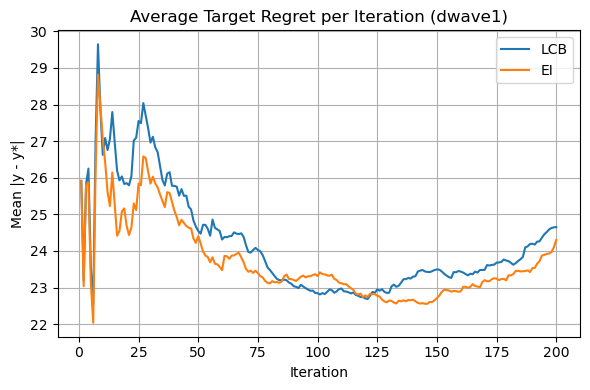

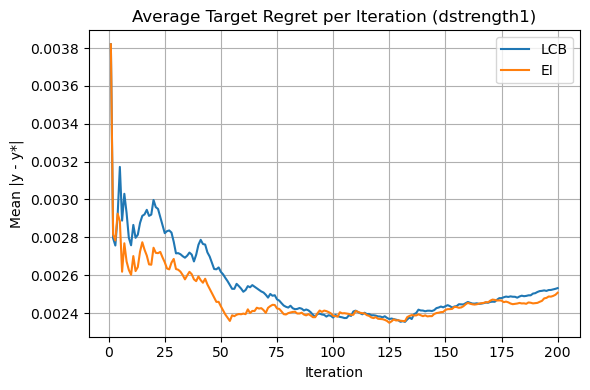

In [37]:
plot_avg_target_regret(df_res, Y_cols)